# **Diamond** price prediction

In [0]:
import numpy as np
import pandas as pd
import io
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LinearRegression, Lasso, LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, KFold
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import LinearSVC

In [2]:
uploaded = files.upload()

Saving data.csv to data (1).csv


In [0]:
diamond = pd.read_csv(io.StringIO(uploaded['data.csv'].decode('utf-8')))

In [5]:
#diamond.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,2.26,Ideal,G,SI2,61.9,57.0,8.44,8.36,5.20,12831
1,2.43,Very Good,H,SI2,63.2,57.0,8.56,8.50,5.39,16170
2,0.80,Premium,F,SI2,61.0,57.0,6.03,6.01,3.67,2797
3,0.40,Ideal,F,I1,63.3,60.0,4.68,4.64,2.95,630
4,0.31,Ideal,G,VS2,61.6,55.0,4.39,4.37,2.70,698


In [6]:
#diamond.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 10 columns):
carat      40455 non-null float64
cut        40455 non-null object
color      40455 non-null object
clarity    40455 non-null object
depth      40455 non-null float64
table      40455 non-null float64
x          40455 non-null float64
y          40455 non-null float64
z          40455 non-null float64
price      40455 non-null int64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.1+ MB


In [7]:
#diamond.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z',
       'price'],
      dtype='object')


    carat: The weight of the diamond, equivalent to 200mg (should be a good indicator)
    cut: Quality of the cut
    color: Color of the diamond from J to D (worst to best)
    clarity: How clear the diamond is; I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best)
    depth: Total depth percentage (relative to x and y). Will likely be collinear
    table: Width of top of diamond relative to widest point (43--95)
    price: In US dollars ($)
    x, y, z: Dimensions of the diamond


### Dealing with x, y, z

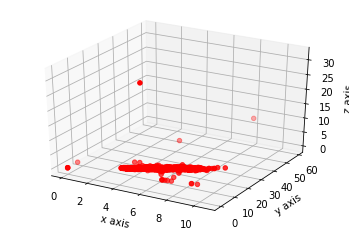

In [8]:
'''
fig= plt.figure()
ax= fig.add_subplot(111,projection='3d')

ax.scatter(diamond['x'], diamond['y'], diamond['z'], c='r', marker='o')

ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')

plt.show()
'''

Regarding the figure above we know there are at least 5 outliers

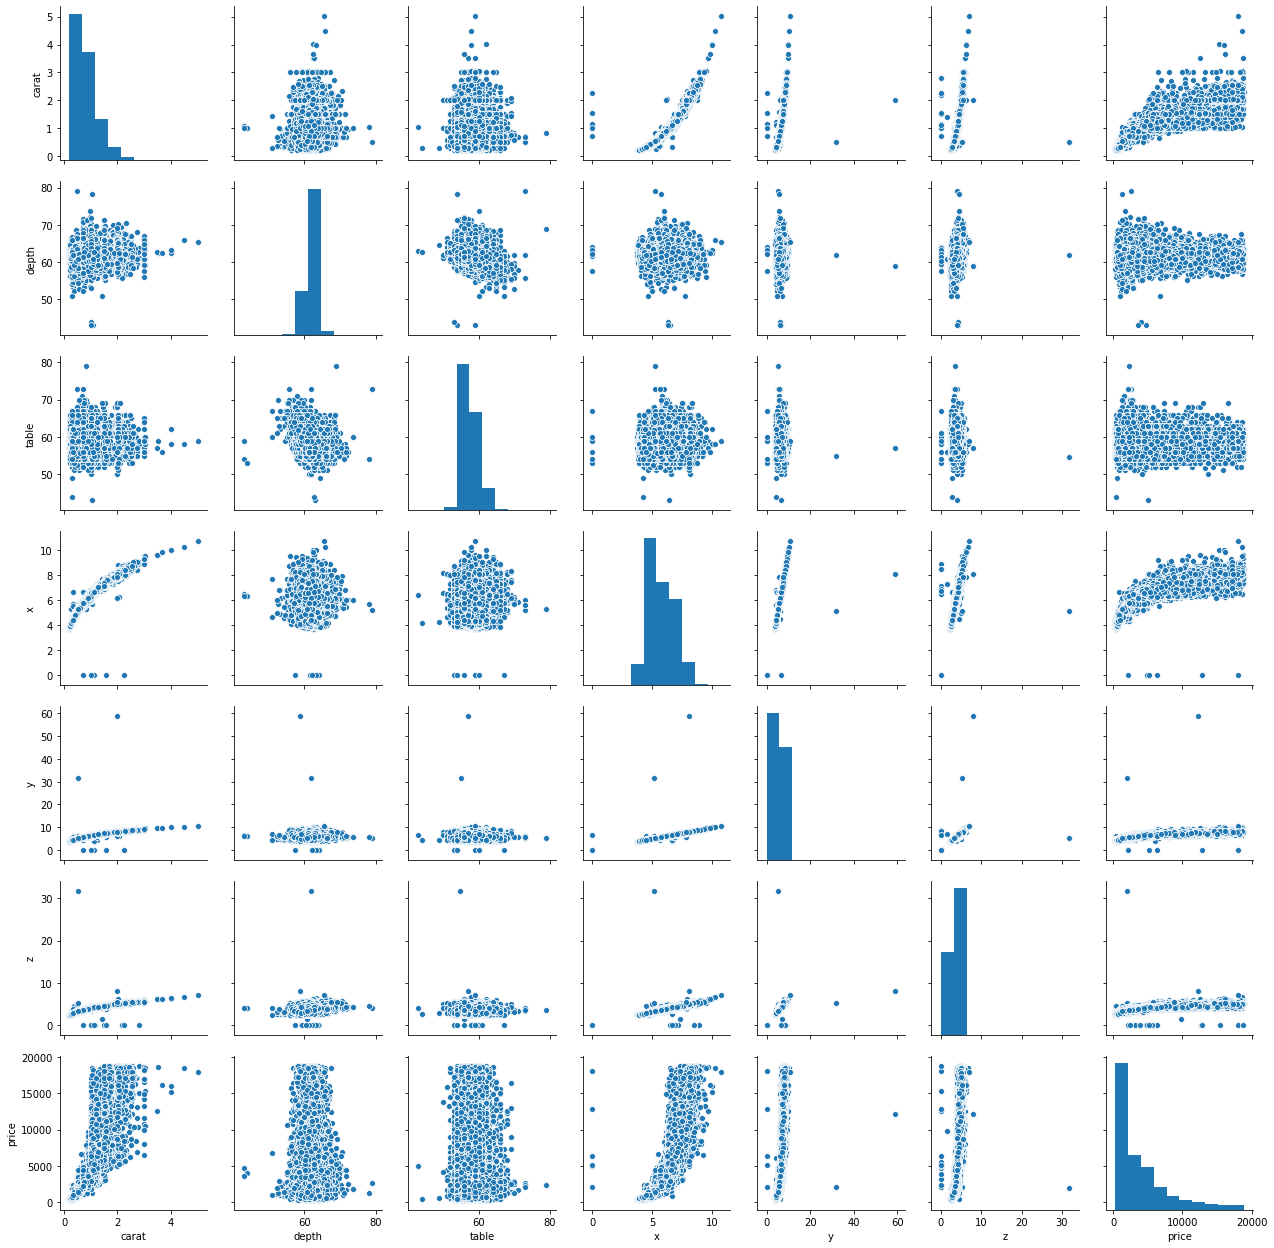

In [9]:
#sns.pairplot(diamond)

As it can be seen in the figure above, those outliers are those in which 'z' and 'y' have values higher than 20, let's get rid of them 

In [10]:
diamond[diamond['z'] > 20]

,carat,cut,color,clarity,depth,table,x,y,z,price
7505,0.51,Very Good,E,VS1,61.8,54.7,5.12,5.15,31.8,1970


In [11]:
diamond[diamond['y']> 20]

,carat,cut,color,clarity,depth,table,x,y,z,price
7416,0.51,Ideal,E,VS1,61.8,55.0,5.15,31.8,5.12,2075
23360,2.00,Premium,H,SI2,58.9,57.0,8.09,58.9,8.06,12210


In [12]:
diamond[diamond['x']> 20]

,carat,cut,color,clarity,depth,table,x,y,z,price


In [0]:
cond = (diamond['y'] > 20) | (diamond['z'] > 20 ) 
diamond.drop(diamond[cond].index, inplace = True)

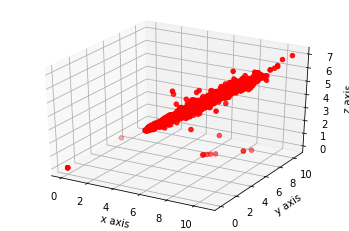

In [14]:
'''
fig= plt.figure()
ax= fig.add_subplot(111,projection='3d')

ax.scatter(diamond['x'], diamond['y'], diamond['z'], c='r', marker='o')

ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')

plt.show()
'''

In [15]:
diamond.describe()

,carat,depth,table,x,y,z,price
count,40452.000000,40452.000000,40452.000000,40452.000000,40452.000000,40452.000000,40452.000000
mean,0.798369,61.748000,57.459226,5.732012,5.733995,3.538688,3939.133121
std,0.474329,1.432305,2.231158,1.123142,1.114617,0.695279,4000.258407
min,0.200000,43.000000,43.000000,0.000000,0.000000,0.000000,326.000000
25%,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000,949.750000
50%,0.700000,61.800000,57.000000,5.700000,5.710000,3.530000,2409.000000
75%,1.040000,62.500000,59.000000,6.540000,6.540000,4.040000,5331.000000
max,5.010000,79.000000,79.000000,10.740000,10.540000,6.980000,18823.000000


Using pd.Categorical, turn 'cut', 'color' and 'clarity into categorical codes

https://stackoverflow.com/questions/38088652/pandas-convert-categories-to-numbers/38089089

In [16]:
print(diamond['clarity'].unique())
print(diamond['color'].unique())
print(diamond['cut'].unique())

['SI2' 'I1' 'VS2' 'SI1' 'VS1' 'VVS2' 'IF' 'VVS1']
['G' 'H' 'F' 'D' 'E' 'I' 'J']
['Ideal' 'Very Good' 'Premium' 'Good' 'Fair']


In [0]:
cut_c = ('Fair', 'Good', 'Very Good', 'Premium', 'Ideal')
color_c = ('J','I','H','G','F','E','D')
clarity_c = ('I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF')

diamond.clarity = pd.Categorical(diamond.clarity, ordered = True, categories = clarity_c)
diamond.cut = pd.Categorical(diamond.cut, ordered = True, categories = cut_c)
diamond.color = pd.Categorical(diamond.color, ordered = True, categories = color_c)

diamond['clarity_c'] = diamond.clarity.cat.codes
diamond['cut_c'] = diamond.cut.cat.codes
diamond['color_c']= diamond.color.cat.codes

In [18]:
'''
print(diamond['clarity_c'].unique())
print(diamond['color_c'].unique())
print(diamond['cut_c'].unique())
'''

[1 0 3 2 4 5 7 6]
[3 2 4 6 5 1 0]
[4 2 3 1 0]


In [0]:
diamond.drop(columns=['clarity','cut','color'], inplace = True)

In [20]:
diamond.head()

,carat,depth,table,x,y,z,price,clarity_c,cut_c,color_c
0,2.26,61.9,57.0,8.44,8.36,5.20,12831,1,4,3
1,2.43,63.2,57.0,8.56,8.50,5.39,16170,1,2,2
2,0.80,61.0,57.0,6.03,6.01,3.67,2797,1,3,4
3,0.40,63.3,60.0,4.68,4.64,2.95,630,0,4,4
4,0.31,61.6,55.0,4.39,4.37,2.70,698,3,4,3


              carat  depth  table         x  ...    price  clarity_c  cut_c  color_c
carat      1.000000    NaN    NaN  0.975009  ...  0.92189        NaN    NaN      NaN
depth           NaN    1.0    NaN       NaN  ...      NaN        NaN    NaN      NaN
table           NaN    NaN    1.0       NaN  ...      NaN        NaN    NaN      NaN
x          0.975009    NaN    NaN  1.000000  ...      NaN        NaN    NaN      NaN
y          0.974511    NaN    NaN  0.998209  ...      NaN        NaN    NaN      NaN
z          0.968886    NaN    NaN  0.986577  ...      NaN        NaN    NaN      NaN
price      0.921890    NaN    NaN       NaN  ...  1.00000        NaN    NaN      NaN
clarity_c       NaN    NaN    NaN       NaN  ...      NaN        1.0    NaN      NaN
cut_c           NaN    NaN    NaN       NaN  ...      NaN        NaN    1.0      NaN
color_c         NaN    NaN    NaN       NaN  ...      NaN        NaN    NaN      1.0

[10 rows x 10 columns]


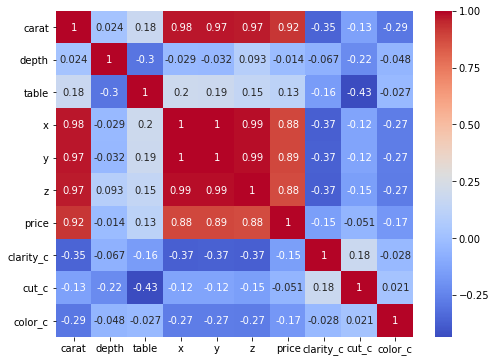

In [21]:
'''
corr_matrix = diamond.corr()
print(corr_matrix[corr_matrix>0.9])
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
'''

**Occam's razor**. If your model is not "that much" worse with less features, then you should probably use less features.


There are three main reasons why you would remove correlated features:

    Make the learning algorithm faster
    Decrease harmful bias
    Interpretability of your model

That's the reason why I rather get rid of the columns x & z


In [0]:
diamond.drop(columns=['x','z'], inplace = True)

In [23]:
#diamond.skew()

carat        1.109343
depth       -0.132863
table        0.710636
price        1.616715
clarity_c    0.548117
cut_c       -0.715428
color_c     -0.190135
dtype: float64

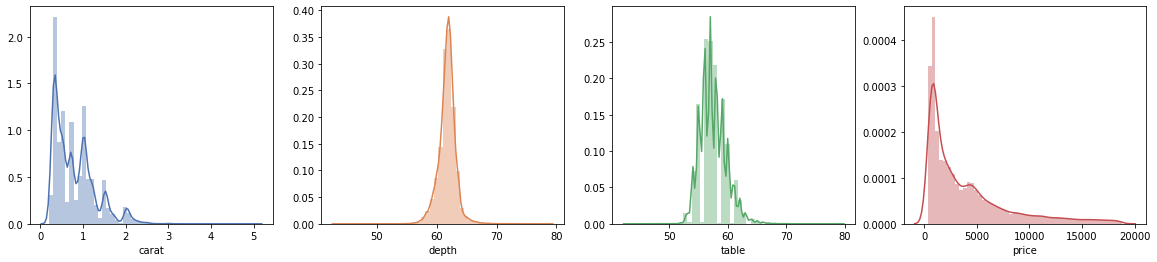

In [24]:
'''
colors = sns.color_palette("deep")
fig,axes = plt.subplots(1,4, figsize = (20,4))
sns.distplot(diamond["carat"], color = colors[0], ax = axes[0])
sns.distplot(diamond["depth"], color = colors[1], ax = axes[1])
sns.distplot(diamond["table"], color = colors[2], ax = axes[2])
sns.distplot(diamond["price"], color = colors[3], ax = axes[3])
plt.show()
'''

Dealing with Outliers

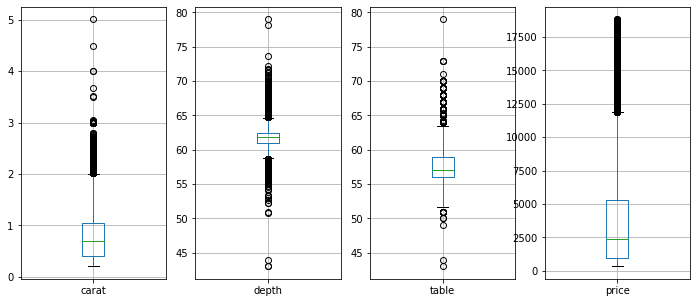

In [25]:
'''
colors = sns.color_palette("deep")
plt.figure(figsize=(12,5))
plt.subplot(1,4,1)
diamond.boxplot(column="carat")
plt.subplot(1,4,2)
diamond.boxplot(column="depth")
plt.subplot(1,4,3)
diamond.boxplot(column="table")
plt.subplot(1,4,4)
diamond.boxplot(column="price")
'''

In [26]:
'''
print(f'{len(diamond[diamond.carat>=3])} diamons with a carat greater than 3')
print(f'{len(diamond[diamond.depth>=72])} diamons with a depth value greater than 72')
print(f'{len(diamond[diamond.table>=70])} diamons with a table value higher than 70')
print(f'{len(diamond[diamond.price>10000])} diamons with a price higher than 10000$')
'''

29 diamons with a carat greater than 3
4 diamons with a depth value greater than 72
12 diamons with a table value higher than 70
3948 diamons with a price higher than 10000$


In [7]:
z = np.abs(stats.zscore(diamond))
print(z)

[[3.08132060e+00 1.06169994e-01 2.05764112e-01 ... 1.24514201e+00
  9.82898287e-01 2.37689899e-01]
 [3.43970798e+00 1.01379841e+00 2.05764112e-01 ... 1.24514201e+00
  8.13048065e-01 8.26168777e-01]
 [3.40547089e-03 5.22188139e-01 2.05764112e-01 ... 1.24514201e+00
  8.49251112e-02 3.50788979e-01]
 ...
 [9.73159554e-01 1.77890440e+00 1.13884918e+00 ... 5.73371572e-01
  8.13048065e-01 1.41464765e+00]
 [1.65247413e-01 2.42917858e-01 6.53968544e-01 ... 1.24514201e+00
  9.82898287e-01 2.37689899e-01]
 [5.44716402e-01 6.61823280e-01 6.90644751e-01 ... 6.38970817e-01
  8.49251112e-02 2.37689899e-01]]


In [8]:
threshold = 3
print(np.where(z > 3))

(array([    0,     1,     1, ..., 40324, 40335, 40437]), array([0, 0, 4, ..., 1, 1, 1]))


In [9]:
diamond_z=diamond[(z<3).all(axis=1)]
diamond_z

,carat,depth,table,y,price,clarity_c,cut_c,color_c
2,0.80,61.0,57.0,6.01,2797,1,3,4
3,0.40,63.3,60.0,4.64,630,0,4,4
4,0.31,61.6,55.0,4.37,698,3,4,3
5,0.53,60.5,60.0,5.23,1132,1,2,4
6,0.70,60.8,61.0,5.64,1987,1,3,6
...,...,...,...,...,...,...,...,...
40450,1.11,62.8,61.0,6.56,5315,2,3,2
40451,0.73,62.6,56.0,5.74,2762,3,4,4
40452,1.26,59.2,60.0,7.02,6855,4,2,1
40453,0.72,61.4,56.0,5.83,2297,1,4,3


In [0]:
damonprice = pd.DataFrame(diamond_z['price'])

In [11]:
damonprice.head()

,price
2,2797
3,630
4,698
5,1132
6,1987


### StandardScaler

In [12]:
scaler= StandardScaler()
diamond_scale=pd.DataFrame(scaler.fit_transform(diamond_z.drop(["price"],axis=1)), columns=diamond_z.drop(["price"],axis=1).columns)
diamond_scale.head()

,carat,depth,table,y,clarity_c,cut_c,color_c
0,0.091382,-0.593366,-0.177177,0.329219,-1.270219,0.043235,0.336374
1,-0.846337,1.223143,1.249338,-0.971657,-1.878321,0.980216,0.336374
2,-1.057324,-0.119494,-1.128187,-1.228034,-0.054014,0.980216,-0.254329
3,-0.541578,-0.988259,1.249338,-0.411426,-1.270219,-0.893747,0.336374
4,-0.143048,-0.751323,1.724843,-0.022113,-1.270219,0.043235,1.517779


## **Train & Test**

In [0]:
X = diamond_scale
y = diamond_z.price

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

## Modelling

In [23]:
models = {
    #"svm": LinearSVC(),
    #"logistic": LogisticRegression(solver='lbfgs', max_iter=2000),
    #"forestCla": RandomForestClassifier(),
    #"forestRe": RandomForestRegressor(random_state=0,n_estimators=75,criterion='mae'),
    "forestRe": RandomForestRegressor(n_estimators=1000, warm_start=False, min_samples_leaf=2, min_samples_split=4)
    #"rid": Ridge()
    #"Gradient": GradientBoostingRegressor(n_estimators=2000, learning_rate = 0.1, loss='ls', max_depth = 3)
}

for modelName, model in models.items():
    print(f"Training model: {modelName}")
    model.fit(X_train, y_train)
    

Training model: forestRe


In [24]:
'''
d = {modelName:model.predict(X_test) for modelName, model in models.items()}
df = pd.DataFrame(d)
df["gt"] = y_test.reset_index(drop=True)
df
'''

,forestRe,gt
0,4550.526667,4516
1,1657.353333,1728
2,3597.040000,3281
3,2097.906667,1824
4,763.346667,781
...,...,...
7737,4797.813333,4576
7738,1116.846667,1138
7739,712.813333,670
7740,12774.053333,13596


In [0]:
kf = KFold(n_splits=2, shuffle=True, random_state=1)
for k,v in models.items():
   scores= cross_val_score(v, X_train, y_train, scoring='r2', cv=kf, n_jobs=5)

print (scores)

## **THE TRUTH'S HOUR**

In [27]:
uploaded = files.upload()

Saving test.csv to test.csv


In [0]:
diamond_t = pd.read_csv(io.StringIO(uploaded['test.csv'].decode('utf-8')))

In [29]:
diamond_t.head()

,id,carat,cut,color,clarity,depth,table,x,y,z
0,0,0.56,Ideal,I,VS2,62.1,54.0,5.30,5.33,3.30
1,1,1.05,Ideal,G,VS2,61.9,56.0,6.56,6.52,4.05
2,2,0.50,Premium,E,VS2,61.5,56.0,5.11,5.07,3.13
3,3,0.80,Ideal,F,VS1,62.8,56.0,5.91,5.96,3.73
4,4,0.54,Ideal,G,VS1,61.4,57.0,5.23,5.20,3.20


In [0]:
cut_c = ('Fair', 'Good', 'Very Good', 'Premium', 'Ideal')
color_c = ('J','I','H','G','F','E','D')
clarity_c = ('I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF')

diamond_t.clarity = pd.Categorical(diamond_t.clarity, ordered = True, categories = clarity_c)
diamond_t.cut = pd.Categorical(diamond_t.cut, ordered = True, categories = cut_c)
diamond_t.color = pd.Categorical(diamond_t.color, ordered = True, categories = color_c)

diamond_t['clarity_c'] = diamond_t.clarity.cat.codes
diamond_t['cut_c'] = diamond_t.cut.cat.codes
diamond_t['color_c']= diamond_t.color.cat.codes

In [0]:
diamond_t.drop(columns=['clarity','cut','color'], inplace = True)

In [0]:
diamond_t.drop(columns=['x','z'], inplace = True)

In [33]:
diamond_t.head()

,id,carat,depth,table,y,clarity_c,cut_c,color_c
0,0,0.56,62.1,54.0,5.33,3,4,1
1,1,1.05,61.9,56.0,6.52,3,4,3
2,2,0.50,61.5,56.0,5.07,3,3,5
3,3,0.80,62.8,56.0,5.96,4,4,4
4,4,0.54,61.4,57.0,5.20,4,4,3


In [0]:
diamondid= pd.DataFrame(diamond_t['id'])

In [35]:
diamondid.head()

,id
0,0
1,1
2,2
3,3
4,4


In [0]:
diamond_t.drop(columns=['id'], inplace = True)

In [37]:
diamond_t.head()

,carat,depth,table,y,clarity_c,cut_c,color_c
0,0.56,62.1,54.0,5.33,3,4,1
1,1.05,61.9,56.0,6.52,3,4,3
2,0.50,61.5,56.0,5.07,3,3,5
3,0.80,62.8,56.0,5.96,4,4,4
4,0.54,61.4,57.0,5.20,4,4,3


In [38]:
'''
scaler= StandardScaler()
diamond_scale=pd.DataFrame(scaler.fit_transform(diamond_t), columns=diamond_t.columns)
diamond_scale.head()
'''

,carat,depth,table,y,clarity_c,cut_c,color_c
0,-0.500241,0.241489,-1.537773,-0.360777,-0.025468,0.977293,-1.413170
1,0.535739,0.101972,-0.646693,0.711770,-0.025468,0.977293,-0.241142
2,-0.627096,-0.177064,-0.646693,-0.595116,-0.025468,0.088755,0.930887
3,0.007178,0.729801,-0.646693,0.207042,0.584539,0.977293,0.344873
4,-0.542526,-0.246823,-0.201152,-0.477947,0.584539,0.977293,-0.241142


In [39]:
diamond_scale.shape

(13485, 7)

In [0]:
pr = {modelName:model.predict(diamond_scale) for modelName, model in models.items()}
dfs= pd.DataFrame(diamondid['id'])
dfs['price'] = pd.DataFrame(pr)

In [53]:
dfs

,id,price
0,0,1253.240000
1,1,6212.573333
2,2,1636.440000
3,3,3393.373333
4,4,1759.720000
...,...,...
13480,13480,1749.713333
13481,13481,1975.373333
13482,13482,9943.373333
13483,13483,491.100000


In [0]:
dfs.to_csv('prueba2.csv', index=False)

In [0]:
files.download('prueba2.csv')